# My First Hotdog detector

--talk about Keras and CNNs--

In [1]:
import keras
from keras import backend as K

Using TensorFlow backend.


We are going to learn some hotdogs! The basic tool we are going to use is a Convolutional Neural Network (CNN). CNNs have revolutionized computer vision in the last few years

In [2]:
from keras.layers import Conv2D, MaxPooling2D, InputLayer, Flatten, Dense

my_first_cnn = keras.Sequential()
my_first_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(72, 72, 3)))
my_first_cnn.add(MaxPooling2D((2,2)))
my_first_cnn.add(Conv2D(32, (3, 3), activation='relu'))
my_first_cnn.add(MaxPooling2D((2,2)))
my_first_cnn.add(Flatten())
my_first_cnn.add(Dense(64, activation='relu'))
my_first_cnn.add(Dense(1, activation='sigmoid'))

my_first_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 70, 70, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                524352    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total para

In [3]:
from keras.preprocessing.image import ImageDataGenerator
import os

base_dir = 'data/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(rescale=1 / 255)
test_datagen = ImageDataGenerator(rescale=1 / 255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(72,72),
                                                    batch_size=100,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(72,72),
                                                        batch_size=100,
                                                        class_mode='binary')

Found 4765 images belonging to 2 classes.
Found 888 images belonging to 2 classes.


In [4]:
from keras.optimizers import Adam

my_first_cnn.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = my_first_cnn.fit_generator(train_generator,
                                     steps_per_epoch=30,
                                     epochs=7,
                                     validation_data=validation_generator,
                                     validation_steps=10)

Epoch 1/7
30/30 [==============================] - 19s 644ms/step - loss: 0.3603 - acc: 0.8821 - val_loss: 0.3115 - val_acc: 0.8664
Epoch 2/7
30/30 [==============================] - 16s 528ms/step - loss: 0.2876 - acc: 0.8644 - val_loss: 0.2615 - val_acc: 0.8684
Epoch 3/7
30/30 [==============================] - 14s 483ms/step - loss: 0.2572 - acc: 0.8740 - val_loss: 0.2496 - val_acc: 0.8704
Epoch 4/7
30/30 [==============================] - 19s 618ms/step - loss: 0.2356 - acc: 0.8783 - val_loss: 0.2449 - val_acc: 0.8704
Epoch 5/7
30/30 [==============================] - 16s 538ms/step - loss: 0.2405 - acc: 0.8811 - val_loss: 0.2409 - val_acc: 0.8816
Epoch 6/7
30/30 [==============================] - 13s 446ms/step - loss: 0.2163 - acc: 0.8937 - val_loss: 0.2278 - val_acc: 0.8877
Epoch 7/7
30/30 [==============================] - 15s 514ms/step - loss: 0.1978 - acc: 0.9050 - val_loss: 0.2344 - val_acc: 0.8937


Magic! In only a few seconds, we are getting classifier with close to 91.6% accuracy.

Now that I come to think of it, we have XXXX hotdog images and XXXX nohotdog images, so a lazy classifier that assigns everything a 'nothotdog' label would get around 87% accuracy. Let's check if that's the case.

### TODO: confusion matrix

Anyway, we have a sweet classifier. But I'm sure it can get better. Let's train it a bit more, shall we?

In [5]:
from keras.optimizers import Adam

my_first_cnn.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history_pt2 = my_first_cnn.fit_generator(train_generator,
                                         steps_per_epoch=30,
                                         epochs=10,
                                         validation_data=validation_generator,
                                         validation_steps=10,
                                         verbose=1)

Epoch 1/10
30/30 [==============================] - 18s 608ms/step - loss: 0.2008 - acc: 0.9028 - val_loss: 0.2412 - val_acc: 0.8927
Epoch 2/10
30/30 [==============================] - 13s 438ms/step - loss: 0.1889 - acc: 0.9097 - val_loss: 0.2272 - val_acc: 0.9028
Epoch 3/10
30/30 [==============================] - 13s 443ms/step - loss: 0.1781 - acc: 0.9190 - val_loss: 0.2547 - val_acc: 0.8988
Epoch 4/10
30/30 [==============================] - 16s 519ms/step - loss: 0.1892 - acc: 0.9082 - val_loss: 0.2224 - val_acc: 0.9028
Epoch 5/10
30/30 [==============================] - 13s 441ms/step - loss: 0.1621 - acc: 0.9333 - val_loss: 0.2515 - val_acc: 0.9008
Epoch 6/10
30/30 [==============================] - 13s 444ms/step - loss: 0.1548 - acc: 0.9277 - val_loss: 0.2262 - val_acc: 0.9211
Epoch 7/10
30/30 [==============================] - 15s 516ms/step - loss: 0.1411 - acc: 0.9356 - val_loss: 0.2271 - val_acc: 0.9221
Epoch 8/10
30/30 [==============================] - 13s 449ms/step - 

What's happening here? We are seeing a typical case of overfitting. Our training loss is improving really fast, but at the same time the validation loss increases in each epoc. The network is learning the specific details of the training set, which don't generalize all that well to the samples in the validation set. 

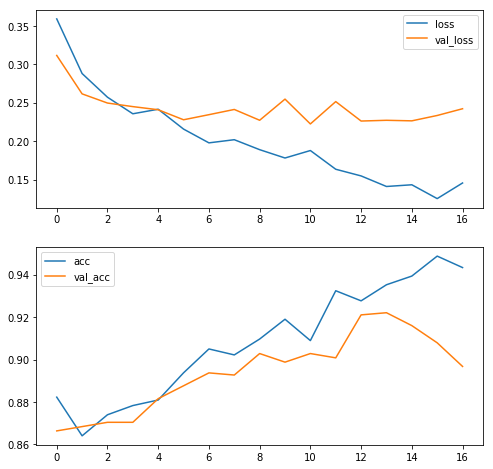

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

f, axes = plt.subplots(2,1)

f.set_size_inches(8,8)

nb_epochs = len(history.epoch)
concatenated = history.epoch + [nb_epochs + epoch_number for epoch_number in history_pt2.epoch]

axes[0].plot(concatenated, history.history['loss'] + history_pt2.history['loss'], label='loss')
axes[0].plot(concatenated, history.history['val_loss'] + history_pt2.history['val_loss'], label='val_loss')
axes[0].legend()

axes[1].plot(concatenated, history.history['acc'] + history_pt2.history['acc'], label='acc')
axes[1].plot(concatenated, history.history['val_acc'] + history_pt2.history['val_acc'], label='val_acc')
axes[1].legend()

This is the tightrope act that we must make all the time when practising Machine Learning: the [bias-variance tradeoff]. In short, that refers to the trade-off between flexibility and generality of the models. A sufficiently flexible (read: complicated) model will always be able to learn non-relevant details of the input dataset (to overfit), and Neural Networks are nothing if not complicated: notice above where we built our simple CNN: it has over $10^6$ parameters! That's over a million knobs to tweak.

Overfitting means we have high variance: different samples will lead to very different estimations of the parameters. That will manifest as higher validation loss than training loss, as we see here from about epoch 8.

The solutions are simple but varied, and we need to keep many of them in our bag of tools for different occasions. Some are very general and some are pretty specific, but all of them fall under the heading of [regularization]. [This] is probably the best explanation of that that I've heard. In short, we want to penalize somehow the complexity of our models. That will in turn result in better generality.

In our specific example, image recognition, there's one very intuitive way to make our model recognize more varied images of hotdogs: to feed it more varied images of hotdogs. Since we already collected as many as we could, what we can do is to _generate_ more varied images of hotdogs.

[bias-variance tradeoff]: https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff
[regularization]: https://en.wikipedia.org/wiki/Regularization_(mathematics)#Generalization
[This]: https://www.coursera.org/lecture/machine-learning/regularization-and-bias-variance-4VDlf

# Data augmentation

The idea is simple: we don't have that many images, so let's make the most of the few we have. We'll generate new images by applying a number of transformations to the ones we have: 

In [7]:
from keras.preprocessing.image import ImageDataGenerator
import os

base_dir = 'data/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(rescale=1 / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1 / 255)

In [8]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(72,72),
                                                    batch_size=100,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(72,72),
                                                        batch_size=100,
                                                        class_mode='binary')

Found 4765 images belonging to 2 classes.
Found 888 images belonging to 2 classes.


In [9]:
my_2nd_cnn = keras.Sequential()
my_2nd_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(72, 72, 3)))
my_2nd_cnn.add(MaxPooling2D((2,2)))
my_2nd_cnn.add(Conv2D(32, (3, 3), activation='relu'))
my_2nd_cnn.add(MaxPooling2D((2,2)))
my_2nd_cnn.add(Flatten())
my_2nd_cnn.add(Dense(64, activation='relu'))
my_2nd_cnn.add(Dense(1, activation='sigmoid'))

my_2nd_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 70, 70, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                524352    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total para

In [10]:
my_2nd_cnn.compile(loss='binary_crossentropy',
                   optimizer=Adam(lr=1e-3),
                   metrics=['acc'])

history = my_2nd_cnn.fit_generator(train_generator,
                                   steps_per_epoch=30,
                                   epochs=25,
                                   validation_data=validation_generator,
                                   validation_steps=10,
                                   verbose=1)

Epoch 1/25
30/30 [==============================] - 22s 726ms/step - loss: 0.3875 - acc: 0.8747 - val_loss: 0.3233 - val_acc: 0.8704
Epoch 2/25
30/30 [==============================] - 17s 558ms/step - loss: 0.2952 - acc: 0.8804 - val_loss: 0.2996 - val_acc: 0.8715
Epoch 3/25
30/30 [==============================] - 17s 551ms/step - loss: 0.2935 - acc: 0.8684 - val_loss: 0.2942 - val_acc: 0.8704
Epoch 4/25
30/30 [==============================] - 19s 628ms/step - loss: 0.2828 - acc: 0.8785 - val_loss: 0.3180 - val_acc: 0.8745
Epoch 5/25
30/30 [==============================] - 18s 585ms/step - loss: 0.2768 - acc: 0.8860 - val_loss: 0.2414 - val_acc: 0.8927
Epoch 6/25
30/30 [==============================] - 17s 550ms/step - loss: 0.2486 - acc: 0.8914 - val_loss: 0.2409 - val_acc: 0.9049
Epoch 7/25
30/30 [==============================] - 17s 552ms/step - loss: 0.2776 - acc: 0.8784 - val_loss: 0.2265 - val_acc: 0.9150
Epoch 8/25
30/30 [==============================] - 17s 555ms/step - 

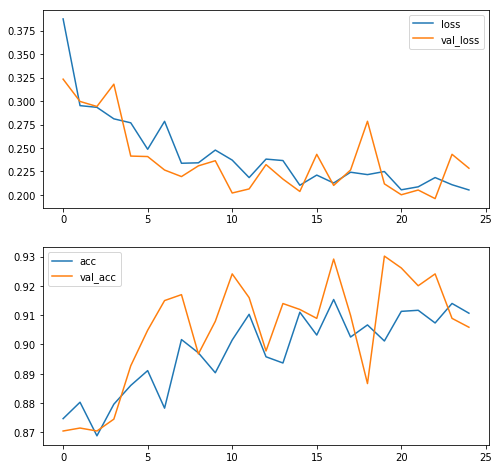

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

f, axes = plt.subplots(2,1)

f.set_size_inches(8,8)


axes[0].plot(history.epoch, history.history['loss'], label='loss')
axes[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
axes[0].legend()

axes[1].plot(history.epoch, history.history['acc'], label='acc')
axes[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
axes[1].legend()

Wow, now I am underfitting! I guess that means I can make my model even a bit more complex, let's see

### One more layer

In [12]:
my_3rd_cnn = keras.Sequential()
my_3rd_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(72, 72, 3)))
my_3rd_cnn.add(MaxPooling2D((2,2)))
my_3rd_cnn.add(Conv2D(32, (3, 3), activation='relu'))
my_3rd_cnn.add(MaxPooling2D((2,2)))
my_3rd_cnn.add(Flatten())
my_3rd_cnn.add(Dense(128, activation='relu'))
my_3rd_cnn.add(Dense(128, activation='relu'))
my_3rd_cnn.add(Dense(64, activation='relu'))
my_3rd_cnn.add(Dense(1, activation='sigmoid'))

my_3rd_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 70, 70, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 33, 33, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
__________

In [13]:
my_3rd_cnn.compile(loss='binary_crossentropy',
                   optimizer=Adam(lr=1e-3),
                   metrics=['acc'])

history = my_3rd_cnn.fit_generator(train_generator,
                                   steps_per_epoch=30,
                                   epochs=20,
                                   validation_data=validation_generator,
                                   validation_steps=10,
                                   verbose=1)

Epoch 1/30
30/30 [==============================] - 21s 699ms/step - loss: 0.3978 - acc: 0.8477 - val_loss: 0.3839 - val_acc: 0.8725
Epoch 2/30
30/30 [==============================] - 15s 516ms/step - loss: 0.3069 - acc: 0.8797 - val_loss: 0.3080 - val_acc: 0.8765
Epoch 3/30
30/30 [==============================] - 15s 513ms/step - loss: 0.2915 - acc: 0.8674 - val_loss: 0.2501 - val_acc: 0.8785
Epoch 4/30
30/30 [==============================] - 17s 582ms/step - loss: 0.3057 - acc: 0.8727 - val_loss: 0.2403 - val_acc: 0.8937
Epoch 5/30
30/30 [==============================] - 16s 529ms/step - loss: 0.2407 - acc: 0.8951 - val_loss: 0.2361 - val_acc: 0.8897
Epoch 6/30
30/30 [==============================] - 16s 520ms/step - loss: 0.2590 - acc: 0.8796 - val_loss: 0.2183 - val_acc: 0.9038
Epoch 7/30
30/30 [==============================] - 15s 512ms/step - loss: 0.2536 - acc: 0.8924 - val_loss: 0.2776 - val_acc: 0.8856
Epoch 8/30
30/30 [==============================] - 16s 519ms/step - 

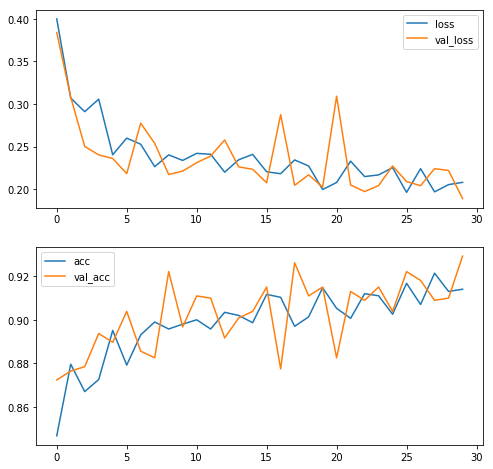

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

f, axes = plt.subplots(2,1)

f.set_size_inches(8,8)


axes[0].plot(history.epoch, history.history['loss'], label='loss')
axes[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
axes[0].legend()

axes[1].plot(history.epoch, history.history['acc'], label='acc')
axes[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
axes[1].legend()

One of the best pieces of advice I got from Jeremy Howard's Deep Learning for Coders is that you should first attempt to overfit, then deal with that through regularization. Let's go for that. 

Once a model stops improving with a particular learning rate, it's useful to reduce the learning rate and keep training.

In [15]:
my_3rd_cnn.compile(loss='binary_crossentropy',
                   optimizer=Adam(lr=1e-4),
                   metrics=['acc'])

history_pt2 = my_3rd_cnn.fit_generator(train_generator,
                                       steps_per_epoch=30,
                                       epochs=20,
                                       validation_data=validation_generator,
                                       validation_steps=10,
                                       verbose=1)

Epoch 1/30
30/30 [==============================] - 28s 930ms/step - loss: 0.1913 - acc: 0.9217 - val_loss: 0.2162 - val_acc: 0.9180
Epoch 2/30
30/30 [==============================] - 18s 601ms/step - loss: 0.1948 - acc: 0.9154 - val_loss: 0.2031 - val_acc: 0.9281
Epoch 3/30
30/30 [==============================] - 16s 542ms/step - loss: 0.1756 - acc: 0.9288 - val_loss: 0.1832 - val_acc: 0.9231
Epoch 4/30
30/30 [==============================] - 18s 593ms/step - loss: 0.1861 - acc: 0.9273 - val_loss: 0.1894 - val_acc: 0.9281
Epoch 5/30
30/30 [==============================] - 15s 508ms/step - loss: 0.1906 - acc: 0.9219 - val_loss: 0.1903 - val_acc: 0.9332
Epoch 6/30
30/30 [==============================] - 16s 535ms/step - loss: 0.1802 - acc: 0.9247 - val_loss: 0.1838 - val_acc: 0.9312
Epoch 7/30
30/30 [==============================] - 16s 519ms/step - loss: 0.1857 - acc: 0.9214 - val_loss: 0.1987 - val_acc: 0.9281
Epoch 8/30
30/30 [==============================] - 16s 540ms/step - 

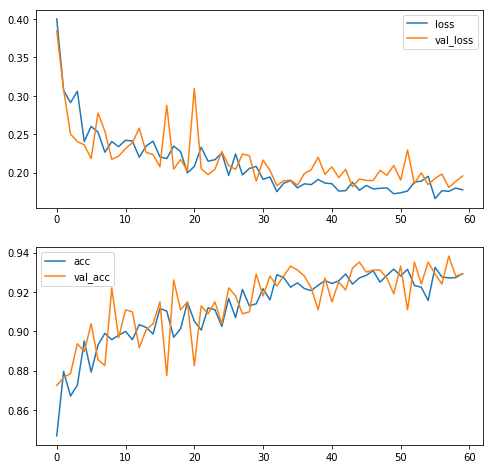

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

f, axes = plt.subplots(2,1)

f.set_size_inches(8,8)

nb_epochs = len(history.epoch)
concatenated = history.epoch + [nb_epochs + epoch_number for epoch_number in history_pt2.epoch]

axes[0].plot(concatenated, history.history['loss'] + history_pt2.history['loss'], label='loss')
axes[0].plot(concatenated, history.history['val_loss'] + history_pt2.history['val_loss'], label='val_loss')
axes[0].legend()

axes[1].plot(concatenated, history.history['acc'] + history_pt2.history['acc'], label='acc')
axes[1].plot(concatenated, history.history['val_acc'] + history_pt2.history['val_acc'], label='val_acc')
axes[1].legend()

### Notes

decreasing learning rate during training: 

```
K.set_value(model.optimizer.lr, 0.001)
model(X,y,nb_epoch=50)
```

### TODOs

Try different image sizes: with 120x120 I got to around 86% accuracy before overfititng. Interestigly, with 72x72 it only a bit lower, around 85%.

Examine the predictions: the most wrong, the most right, etc.

SGD with restarts, maybe with Learning Rate Scheduler?

### Obsolete

In my case, the first few times I tried to train this network, it was not learning anything at all - its predictions were no better than chance. Only when I added a second Dense layer in order to make it be able to fit anything at all did I get any useful results at all.